# CNN MODELİ İLE MANTAR TÜRÜ TESPİTİ

Öğrenme aktarımı yöntemlerinden faydalanarak mantar türlerini tespit eden bir Cnn modelini Google Colaboratory üzerinde geliştirdim. Hazırlanan bu model, 77 adet mantar türünü mantar resimlerini analiz ederek sınıflandırmaktadır. Model daha sonra geliştirilecek olan bir mobil uygulamaya entegre edilerek sınıflandırma işlemlerini mobil ortamda gerçekleştirecektir. Burada modelin nasıl, hangi yöntemlerle ve hangi kodlar kullanılarak hazırlandığını inceleyebilirsiniz.

## Veri Seti İle İlgili İşlemler

Burada veri setini indirme, sıkıştırılmış klasörden çıkarma, eğitim(train) ve doğrulama(validation) verileri olarak bölünmesi yer almaktadır.

### Verinin indirilmesi ve sıkıştırılmış klasörden çıkartılması.

Benim kullanacak olduğum veri setim drive yüklü durumda. Direk dirve ile bağlantı kurarak dirve'da bulunan dosyaları kullanabilirim.


In [ ]:
# indirilen veri seti bu fonksiyon ile sıkıştırılmış klasörden çıkartılacaktır.
import zipfile
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
# veri seti drive'da olduğu için drive'ı colaboratory'e bağlayıp direk path vererek unzip işlemini yaptım.
# "zip" dosyasına sağ tıklayıp path'i kopyalayarak unzip_data içerisine parametre olarak verebilirsiniz.
unzip_data("/content/drive/MyDrive/CNNs/Multiclass_Classification/Mantar/Veri/mantar_veri_seti77.zip")

### Verilerin train ve validation olmak üzere tensörlerde tutulması

Zip dosyasından çıkartılan klasörün içerisinde train ve validasyon olmak üzere iki klasör bulunmaktadır. Bu klasörler altında bulunan resimler modelin eğitimi sırasında kullanılması gerekmektedir. Bu nedenle bu resimleri yığınlar haline Tensorflow tensörlerinde tutmamız gerekiyor.

Mantar resimleri 32'şer yığınlar şeklinde her bir resmin boyutu 224x224 olacak şekilde tensörlere yerleştirilecektir.

In [ ]:
import tensorflow as tf

# zip dosyasından çıkan klasörde bulunan mantar_train ve mantar_validation path'lerini değişkenlerde tutuyoruz
train_dir = "/content/mantar_veri_seti77/mantar_train"
val_dir = "/content/mantar_veri_seti77/mantar_validation"

IMG_SIZE = (224, 224) # resimlerin boyutu sabitlendi. Bu değer değişiklik gösterebilir. İdeal değerlerden biri de 224x224'tür



Aşağıda bulunan hücrede veriler tensörlere yerleştirilerek kullanıma hazır hale getiriliyor.



**`image_dataset_from_directory()`** fonksiyonu ile bu işlemi gerçekleştirebiliyoruz. Fonsiyonu daha ayrıntılı incelemek ve aldığı parametreleri görmek için [Tıklanız.](https://keras.io/api/preprocessing/image/)

Burada;


* **image_size:** resimlerin boyutu sabitleniyor. 224x224 olarak tanımlamıştık.
*   **batch_size:** her bir yığında bulunan resim sayısı
*   **label_mode:** etiketlerin nasıl kodlandığını belirtmektedir. Burada bizim etiketlerimiz kategörik vektörde yani "one-hot" şeklinde tutulmaktadır.







In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32,
                                                                 label_mode="categorical")

validation_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical", 
                                                                batch_size=32,                                                               
                                                                shuffle=False) # validasyon da doğrulama gerçekleştiği için karıştırma özelliği kapatılmalı.

Found 6733 files belonging to 77 classes.
Found 231 files belonging to 77 classes.


## Data Augmentation(Veri Artırım) Katmanı Oluşturma

Veri sayısı derin öğrenmede oldukça önemlidir. Sayının fazla olması öğrenme için olumlu bir şeydir. Bu nedenle bir data augmentation katmanı oluşturulmuştur. Bu katman Keras functional API kullanarak modele entegre edilecektir. Bu sayede sadece eğitim anında veri artırımı gerçekleşmiş olacaktır. Modelin eğitiminde kim nerede ve zaman istere istesin bundan faydalanabilecektir.


In [ ]:
# Veri artırımı için bir data augmentation katmanı oluşturulması.

# import tensorflow as tf , daha önce dahil edilmişti. Dahil edilmediyse ediniz.
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)                          
], name = "data_augmentation")

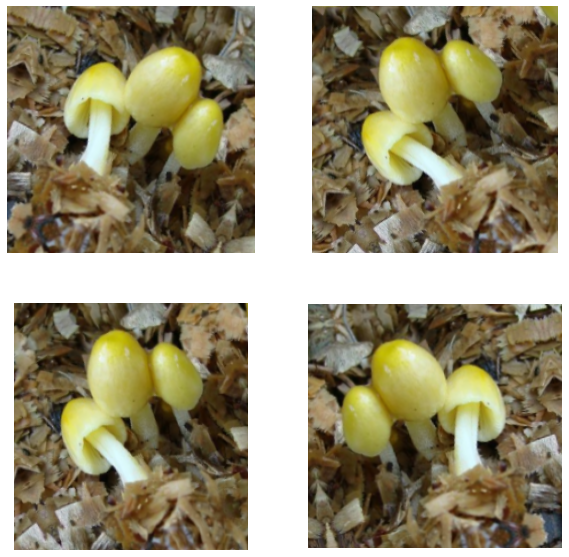

In [ ]:
# Data augmentation katmanının yaptığı işi görmek için bu kod hücresi çalıştırılabilir.

import matplotlib.pyplot as plt
for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Modelin Hazırlanması

Model olarak ImageNet1k ile eğitilmiş bir model olan EfficientNetV2B1 modeli kullanılacaktır. Model functional API ile son katmanı olmadan indiriliyor. Çünkü son katman eğitimin gerçekleşeceği veride bulunan sınıf sayısına göre ayarlanmalıdır. Burada Öğrenme Aktarımı (Transfer Learning) uygulanacağı için model dondurulması (katmanların eğitilebilirliğinin kapatılması) oldukça önemlidir. Bu sayede önceden öğrenilmiş ağırlıklarda bir değişiklik olmayacaktır.

Aşağıda model çekilerek gerekli eklemeler ve ayarlamalar yapılmıştır. Ardından ilk eğitim aşaması olarak 25 epoch'luk bir eğitim gerçekleştiriliyor.

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B1(include_top=False) # modelin alınması. son katmanı almamak için False
base_model.trainable= False #Katmanları dondurmak için modelin eğitilebilir durumu false yapılmalı.


inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer") # bir adet giriş katmanı oluşturuldu.

#EfficientNet serisi modellerde ölçekleme katmanı modelin içerisinde yer alıyor.
# Başka bir model kullanıyor ve içerisinde ölçekleme katmanı yoksa aşağıdaki kod eklenebilir.
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs) 

#Zincir şeklinde, oluşturulan katmanlar ana modele ekleniyor
x = data_augmentation(inputs) 
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)  #pooling işlemi için bir katman

#Çıkış katmanı oluşturulur. 77 adet sınıf olduğu için 77 adet nöron eklendi ve activation fonk. olarak softmax kullanıldı.
# softmax çoklu sınıflandırmalarda kullanılır.
outputs = tf.keras.layers.Dense(77, activation="softmax", name="output_layer")(x) 

model = tf.keras.Model(inputs,outputs) # akışın girişten çıkışa doğru oldu belirtiliyor.

#model derlenir
model.compile(loss="categorical_crossentropy",  
               optimizer=tf.keras.optimizers.Adam(), # optimizasyon için Adam seçildi.
               metrics=["accuracy"])

# modelin eğitimi.
history_model1= model.fit(train_data, epochs=25, steps_per_epoch=len(train_data),
                           validation_data= validation_data, validation_steps=len(validation_data))

28467200/28456008 [==============================] - 1s 0us/step
Epoch 1/25
211/211 [==============================] - 149s 615ms/step - loss: 2.8566 - accuracy: 0.3575 - val_loss: 2.0017 - val_accuracy: 0.5281
Epoch 2/25
211/211 [==============================] - 96s 448ms/step - loss: 1.6368 - accuracy: 0.6318 - val_loss: 1.4246 - val_accuracy: 0.6623
Epoch 3/25
211/211 [==============================] - 82s 384ms/step - loss: 1.2636 - accuracy: 0.7079 - val_loss: 1.1679 - val_accuracy: 0.7446
Epoch 4/25
211/211 [==============================] - 79s 368ms/step - loss: 1.0594 - accuracy: 0.7493 - val_loss: 0.9908 - val_accuracy: 0.7835
Epoch 5/25
211/211 [==============================] - 71s 331ms/step - loss: 0.9274 - accuracy: 0.7760 - val_loss: 0.8876 - val_accuracy: 0.8139
Epoch 6/25
211/211 [==============================] - 67s 313ms/step - loss: 0.8325 - accuracy: 0.8053 - val_loss: 0.8202 - val_accuracy: 0.8268
Epoch 7/25
211/211 [==============================] - 67s 313ms/

In [ ]:
# ilk eğitim aşaması yapılan model drive kaydedildi.
model.save("/content/drive/MyDrive/CNNs/Multiclass_Classification/Mantar/Mantar_modelleri/feature_extr_model1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CNNs/Multiclass_Classification/Mantar/Mantar_modelleri/feature_extr_model1/assets


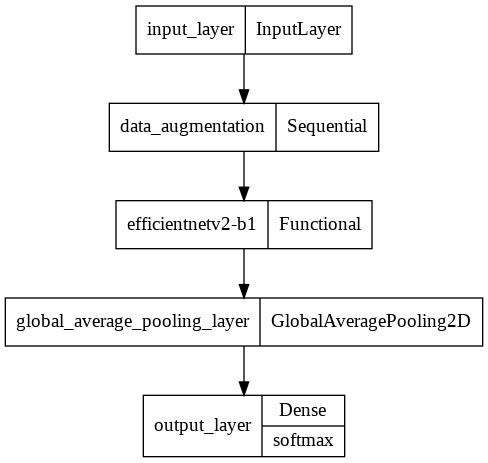

In [ ]:
#Modelin yapısının çizdirilmesi
keras.utils.plot_model(
    model,
    to_file="model1.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

### Loss ve accuracy eğrilerinin çizdirilmesi

Loss ve accuracy eğrilerini çizdirmek ve yorumlama önemlidir. Bu eğri grafikleri bize modelin öğrenme durumunun iyi olup olmadığı, aşırı öğrenme(overfitting) ya da az öğrenme(underfitting) durumları olup olmadığı hakkında bilgiler verebilmektedir.

Eğitim ve doğrulama eğrilerini grup halinde birlikte çizdirebilmek için aşağıdaki fonksiyon kullanılmaktadır. Bu fonksiyon parametre olarak modelin history(geçmiş) nesnesini almaktadır. 

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Ayrı ayrı olmak üzere training ve validation metrikleri için kayıp(loss) ve doğruluk(accuracy) eğrilerini döndürür.
  
  Args:
    history: TensorFlow modelinin History nesnesi (bakınız: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Loss çizdir
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Accuracy çizdir
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

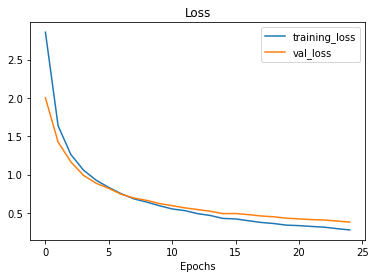

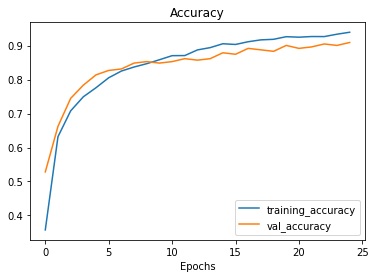

In [ ]:
plot_loss_curves(history_model1)

## Fine-Tuning

İlk kısımda ana modele sadece giriş katmanı, DA katmanı, çıkış katmanı ve çıkış katmanından önce yer alan bir adet pooling katmanı eklenmişti. Modelin diğer katmanları dondurularak ağırlıkları korunmuştu. Burada modelin sondan on beş katmanının eğitilebilir özelliğini açarak eğitilecek. Bu sayede ince ayarlamalar yapılarak modelin performansını biraz daha yükseltmek istenmektedir.

İlk önce 25 epoch'luk bir eğitim yapılmıştı. Şimdi aynı kalınan yerden modelde değişiklik yapılarak eğitime devam edilecek. Burada da 10 epoch'luk bir eğitim yapılacak olup toplamda 35 epoch'luk bir model eğitimi olmuş olacak.



In [ ]:
base_model.trainable= True  # tüm katmanlar eğitilebilir hale getiriliyor.

for layer in base_model.layers[:-15]: # son 15 katman haricindeki tüm katmanlar donduruluyor.
  layer.trainable = False


model.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(0.00001), # öğrenme hızı normalden 100x düşürüldü. Fine-tuning de tasvsiye ediliyor.
               metrics=["accuracy"]) 

history_fine_tune_model1 = model.fit(train_data,
                                      epochs=35,
                                      validation_data= validation_data,
                                      validation_steps=len(validation_data),
                                      initial_epoch= history_model1.epoch[-1]) # bir önceki eğitimin son epoch'undan devam et

Epoch 25/35
211/211 [==============================] - 62s 233ms/step - loss: 0.2384 - accuracy: 0.9445 - val_loss: 0.3420 - val_accuracy: 0.9091
Epoch 26/35
211/211 [==============================] - 45s 210ms/step - loss: 0.2157 - accuracy: 0.9459 - val_loss: 0.3313 - val_accuracy: 0.9134
Epoch 27/35
211/211 [==============================] - 45s 206ms/step - loss: 0.2046 - accuracy: 0.9479 - val_loss: 0.3263 - val_accuracy: 0.9134
Epoch 28/35
211/211 [==============================] - 45s 207ms/step - loss: 0.2037 - accuracy: 0.9459 - val_loss: 0.3276 - val_accuracy: 0.9177
Epoch 29/35
211/211 [==============================] - 44s 203ms/step - loss: 0.1920 - accuracy: 0.9476 - val_loss: 0.3257 - val_accuracy: 0.9134
Epoch 30/35
211/211 [==============================] - 45s 208ms/step - loss: 0.1951 - accuracy: 0.9465 - val_loss: 0.3189 - val_accuracy: 0.9264
Epoch 31/35
211/211 [==============================] - 45s 209ms/step - loss: 0.1963 - accuracy: 0.9464 - val_loss: 0.3174 -

In [ ]:
model.save("/content/drive/MyDrive/CNNs/Multiclass_Classification/Mantar/Mantar_modelleri/fine-tuning_model1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CNNs/Multiclass_Classification/Mantar/Mantar_modelleri/fine-tuning_model1/assets


### Feature extraction ile fine-tuning karşılaştırılması

In [ ]:
# fine-tuning den öncesini ve sonrasını karşılaştırmak için
import matplotlib.pyplot as plt
def compare_historys(original_history, new_history, initial_epochs=25):
    """
    İki tensorflow modelinin History nesnesini karşılaştırır.
       
    Args:
      orginal_history: ilk oluşturulan modelin history nesnesi    
      new_history: fine-tuning işleminden sonra ki modelin history nesnesi     
      initial_epochs: ilk kısımda(orjinal model) modelin epochs sayısı 
       
    """
    
    # orjinal modelin history değerleri
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    
    # orjinal history ile yeni history'nin birleştirilmesi
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Grafik olarak çizdirilmesi
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs, initial_epochs],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs, initial_epochs],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

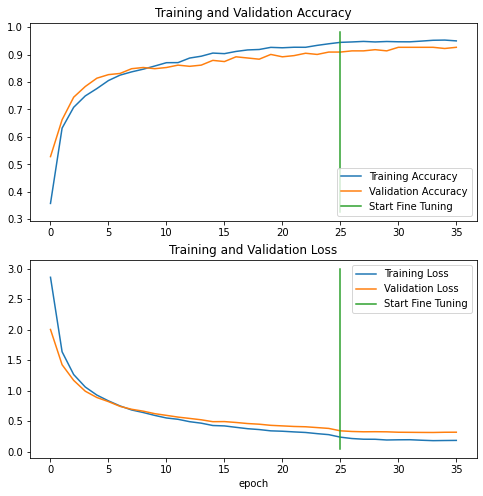

In [ ]:
compare_historys(original_history= history_model1, new_history= history_fine_tune_model1, initial_epochs=25)

## Modelin Testi ve Manuel Çalıştırılması

Modelin testi için 400 resimden oluşan bir test verisi hazırlanmıştır. Aşağıda bu test verisinin tensörlere yerleştirilerek, modelin değerlendirmesi gerçekleştirilmiştir.

Ayrıca modele manuel olarak resim vermek ve döndürdüğü sonuçları görmek için iki adet fonksiyon oluşturulmuştur. 

`load_and_prep_image` fonksiyonu modele tahminde bulunması için verilecek resmi okuyarak, resmin özelliklerini ayarlamaktadır. 

`pred_and_plot` fonksiyonu ise modelin istenilen mantarın türü hakkında tahminde bulunması ve bu resim ile birlikte tahmin sonuçlarını ekrana bastırmasını sağlamaktadır.


In [ ]:
# Test verileri kullanılmak üzere ayarlanıyor
unzip_data("/content/drive/MyDrive/CNNs/Multiclass_Classification/Mantar/Veri/mantar_test.zip")

IMG_SIZE = (224, 224)
test_dir="/content/mantar_test"
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical", 
                                                                batch_size=32,                                                               
                                                                shuffle=False)

Found 400 files belonging to 77 classes.


In [ ]:
#Test verisi ile model değerlendiriliyor.
model.evaluate(test_data)

13/13 [==============================] - 16s 267ms/step - loss: 0.1441 - accuracy: 0.9700


[0.14413540065288544, 0.9700000286102295]

In [ ]:
class_names= train_data.class_names # veri setindeki sınıflar

def load_and_prep_image(filename, img_shape=224):
  """
  path'i verilen resmi okur ve tensör içine koyarak geri dönderir. 
  Aynı zamanda resmi şu şekilde düzenler-> (img_shape, img_shape, colour_channel).
  """
  # İstenilen resmin okunması
  img = tf.io.read_file(filename)

  # okunan resim decode edilerek tensor içerisine 3 kanal olarak konulur . 
  # (bizim verimizdeki eğitim seti 3 kanallı resimler içeriyordu. Bazı veriler 4 kanala sahip olabilir)
  img = tf.image.decode_image(img, channels=3)

  # Resim yeniden boyutlandırılıyor (modelin eğitildiği veri ile aynı hale getiriliyor)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Normalize ediliyor/Ölçeklendiriliyor (tüm değerler 0 ile 1 arasında olacak şekilde)
  #img = img/255.
  return img

def pred_and_plot(model, filename, class_names):
  """
  Verilen resmin türü hakkında tahmin yapar ve resimin görüntüsünü ile birlikte
  tahmin oranı ve tahmin ettiği sınıfın ismini yazdırır. 
  """
  # Üstte oluşturulan fonksiyonu kullanılarak resim tahmin için hazır hale getiriliyor.
  img = load_and_prep_image(filename)

  # Tahmin yapılması
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Tahmin edilen sınıfın getirilmesi. Hem multi-class hem de binnary kullanım için uygundur.
  if len(pred[0]) > 1: # multi-class mı diye kontrol ediliyor
    pred_class = class_names[pred.argmax()] # Eğer birden fazla tahmin varsa en büyüğünü alır.
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # Tek bir tahmin varsa onu getirir.(binnary için)

  
  # Resmin çizdirilmesi ve tahmin sonucunun yazdırılması.
  print(pred)
  plt.imshow(img/255)
  plt.title(f"Prediction: {100*tf.reduce_max(pred):.2f}% {pred_class}")
  plt.axis(False); 

Yukarıda oluşturulan fonksiyonları kullanarak modele tahmin yaptırılması ve sonuçları gösterilir. İlk bastırılan çıktı, bu resmin hangi türe ait olabileceğinin oranlarıdır. Buradan en yüksek oran alınarak oran, sınıf ismi(resmin etiketi) ve resmin kendisi bastırılmaktadır.

[[9.93673086e-01 1.08465823e-08 9.57561763e-09 4.02209999e-08
  3.27584782e-09 5.58035528e-11 4.07184746e-12 2.86586199e-10
  1.72547452e-08 2.05896331e-08 2.60607198e-08 1.85676231e-11
  4.48810660e-08 2.25293534e-05 1.22349036e-07 8.72022042e-07
  1.19656007e-09 2.32163044e-09 6.14782614e-10 2.15712225e-05
  3.59822856e-08 2.50633207e-07 3.70464805e-11 3.46141071e-09
  1.49193255e-12 1.13160255e-04 8.78567371e-05 2.86828090e-05
  6.54523769e-10 2.84344603e-10 7.03570313e-10 2.04012636e-07
  1.19842847e-09 6.33756798e-08 6.09524761e-07 1.44696463e-10
  7.55708107e-10 6.35207834e-06 5.36092004e-10 6.84748238e-06
  2.77198092e-06 1.15004383e-07 2.33918544e-11 1.46901824e-08
  3.75107135e-07 1.04940014e-07 1.17041139e-07 1.72184803e-12
  3.78724650e-07 8.77690098e-08 8.91518448e-06 2.39514769e-10
  1.63048696e-06 4.23185014e-07 6.29495673e-08 3.24604218e-04
  3.59666394e-08 3.57876964e-08 1.61550719e-08 3.19071125e-09
  9.46927685e-05 1.28055910e-06 1.56509614e-11 2.99246040e-07
  5.5664

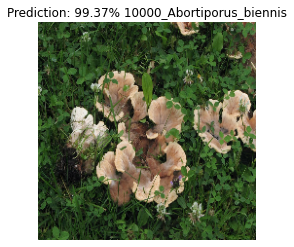

In [ ]:
pred_and_plot(model, filename="/content/mantar_veri_seti77/mantar_validation/10000_Abortiporus_biennis/FVL2009PIC65515416.JPG", class_names=class_names)

## Modelin Tflite Modeline Dönüştürülmesi ve Kaydedilmesi

Oluşturduğumuz modeli, mobil cihazlarda kullanmak için tflite modeline dönüştürmemiz gerekmektedir. Bunun için aşağıdaki kod hücresi kullanılmıştır.

In [ ]:
import tensorflow as tf

kayitli_model = "/content/drive/MyDrive/CNNs/Multiclass_Classification/Mantar/Mantar_modelleri/fine-tuning_model1" 

converter = tf.lite.TFLiteConverter.from_saved_model(kayitli_model) # kayıtlı modelin bulunduğu klasör parametre olarak verilir
tflite_model = converter.convert()

# Dönüştürülen model kaydedilir
with open("/content/drive/MyDrive/CNNs/Multiclass_Classification/Mantar/Mantar_modelleri/model.tflite", 'wb') as f:
  f.write(tflite_model)